## Task 2

Use N -grams as features for a Naive Bayes-classifier that can distinguish
between reviews from the corpus and reviews generated by your solution to 
Task 1!

We have two classes `orig` for reviews from the corpus and `gen` for generated
reviews.

1. Implement a Naive-Bayes-classifier that takes the 3-grams in a sample
    (either from `orig` or `gen`) as input and maps them to `orig` or `gen`!
    Take 5,000 random reviews from the corpus and generate 5,000 reviews 
    using 3-grams to estimate the conditional distribution you need for 
    the Naive Bayes-classifier!
1
2. For evaluation, implement the following loop:
    - Randomly (with uniform distribution) decide whether you take a random
        review for the corpus that has not been used for training or generate
        a new review using your Generative AI!
    - Your decision determines the ground truth for the sample.
    - Classify the sample using your Naive Bayes-classifier!
    - If the sample was misclassified, add it to the training data and
        re-estimate the conditional distributions.

3. Iterate this loop 1,000 times and report the classifier performance always after 100 iterations!

Ans. During our experiments, we observe that 1,000 iteration are too less for the model to learn
    any patterns.

4. Can you find a trend in the performance over time?

Ans. We observer, given enough iterations, the performance of the model increases over time.

In [14]:
import pandas as pd

imdb_reviews = pd.read_csv("imdb_reviews.csv")[:5000]
artificial_reviews = pd.read_csv("artificial_reviews.csv")

# unseen reviews. Used for online training
imdb_unseen  = pd.read_csv("imdb_reviews.csv")[5000:]

In [15]:
# apply labels on original and generated data
imdb_reviews["label"] = "orig"
artificial_reviews["label"] = "gen"

In [16]:
artificial_reviews = artificial_reviews.rename(columns={"artificial_reviews": "review"})
artificial_reviews.head()

,review,label
0,this is the story entirely takes place in cine...,gen
1,ve had better parts of the revolution perform ...,gen
2,by some as young bull is killed by the doctor ...,gen
3,this is amazingly open about the film makers s...,gen
4,director alfred green baby face makes her love...,gen


In [17]:
all_reviews = pd.concat([imdb_reviews, artificial_reviews])
all_reviews.head()

,review,label
0,This is a great movie for the true romantics a...,orig
1,I saw this film when I was a young child on te...,orig
2,I consider myself a great admirer of David Lyn...,orig
3,Cat Soup at first seems to be a very random an...,orig
4,"Back in 1994, I had a really lengthy vacation ...",orig


In [18]:
# create training and testing sets
from sklearn.model_selection import train_test_split

X, y = all_reviews["review"], all_reviews["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# trigram_hvectorizer = CountVectorizer(ngram_range=(3,3))
trigram_hvectorizer = HashingVectorizer(
    ngram_range=(3, 3),
    analyzer="word",
    lowercase=True,
    alternate_sign=False,
    n_features=2**20
)

X_train_vec = trigram_hvectorizer.fit_transform(X_train)

# Encode labels
y_train_encoded = y_train.map({'orig': 0, 'gen': 1})

# https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
nb = MultinomialNB()

# what if we do not fit the model initially ? -> it does not make much difference. The max accuracy is same
nb.fit(X_train_vec, y_train_encoded)

# # Test
X_test_vec = trigram_hvectorizer.transform(X_test)
y_test_encoded = y_test.map({'orig': 0, 'gen': 1})
preds = nb.predict(X_test_vec)

print("\nInitial Metrics")
print(f"F1 score: {f1_score(y_test_encoded, preds):.2f}")
print(f"Precision: {precision_score(y_test_encoded, preds):.2f}")
print(f"Recall: {recall_score(y_test_encoded, preds):.2f}")
print(f"Accuracy: {accuracy_score(y_test_encoded, preds):.2f}")


Initial Metrics
F1 score: 0.04
Precision: 0.83
Recall: 0.02
Accuracy: 0.50


## Online training

In this task, we want to be able to train the model incrementally i.e. online. Therefore
we need the generate_text_ngrams function from task1. I'll just copy over that code.

In [20]:
initial_prefixes = pd.read_csv("initial_prefixes.csv")

def random_initial_prefix() -> str:
    return random.choices(initial_prefixes["initial_prefix"], initial_prefixes["frequency"])[0]

In [21]:
import random
import numpy as np
from sklearn.metrics import accuracy_score
from utils import generate_text_ngrams_model

nb.partial_fit(X_train_vec[:1], y_train_encoded[:1], classes=np.array([0, 1]))

# Pool of unseen orig reviews
unseen_orig = imdb_unseen['review'].tolist()
random.shuffle(unseen_orig)

# Tracking
correct = 0
total = 0
accuracies = []
baseline_accuracies = []

NUM_ITERATIONS = 5_000

for i in range(1, NUM_ITERATIONS+1):
    if random.choice([False, True]):
        # Generate new gen review
        prefix = random_initial_prefix()
        sample_review = generate_text_ngrams_model(3, prefix, random.randint(30,50))
        true_label = 1  # 'gen'
    else:
        # Take from unseen orig
        if unseen_orig:
            sample_review = unseen_orig.pop()
            true_label = 0  # 'orig'
        else:
            # Fallback if pool empty
            sample_review = random.choice(imdb_reviews['review'].tolist())
            true_label = 0

    # Vectorize the sample
    sample_vec = trigram_hvectorizer.transform([sample_review])

    # Predict
    pred_label = nb.predict(sample_vec)[0]

    # Check accuracy
    total += 1
    if pred_label == true_label:
        correct += 1

    # If misclassified, add to training
    if pred_label != true_label:
        nb.partial_fit(sample_vec, np.array([true_label]))

    # Report every 100
    if i % 100 == 0:
        batch_acc = correct / total  # Per-batch accuracy
        accuracies.append(batch_acc)

        # Baseline accuracy
        preds = nb.predict(X_test_vec)
        baseline_acc = accuracy_score(y_test_encoded, preds)
        baseline_accuracies.append(baseline_acc)

        print(f'Iteration {i}   Baseline Accuracy: {baseline_acc:.4f}')
        print(f"Iteration {i}:  Batch Accuracy = {batch_acc:.4f}\n")

        # Reset for next batch
        correct = 0
        total = 0

Iteration 100   Baseline Accuracy: 0.5060
Iteration 100:  Batch Accuracy = 0.4800

Iteration 200   Baseline Accuracy: 0.5080
Iteration 200:  Batch Accuracy = 0.5700

Iteration 300   Baseline Accuracy: 0.5120
Iteration 300:  Batch Accuracy = 0.4900

Iteration 400   Baseline Accuracy: 0.5180
Iteration 400:  Batch Accuracy = 0.5900

Iteration 500   Baseline Accuracy: 0.5180
Iteration 500:  Batch Accuracy = 0.5700

Iteration 600   Baseline Accuracy: 0.5190
Iteration 600:  Batch Accuracy = 0.4800

Iteration 700   Baseline Accuracy: 0.5200
Iteration 700:  Batch Accuracy = 0.5300

Iteration 800   Baseline Accuracy: 0.5220
Iteration 800:  Batch Accuracy = 0.5800

Iteration 900   Baseline Accuracy: 0.5240
Iteration 900:  Batch Accuracy = 0.5600

Iteration 1000   Baseline Accuracy: 0.5270
Iteration 1000:  Batch Accuracy = 0.5900

Iteration 1100   Baseline Accuracy: 0.5290
Iteration 1100:  Batch Accuracy = 0.5800

Iteration 1200   Baseline Accuracy: 0.5290
Iteration 1200:  Batch Accuracy = 0.4800

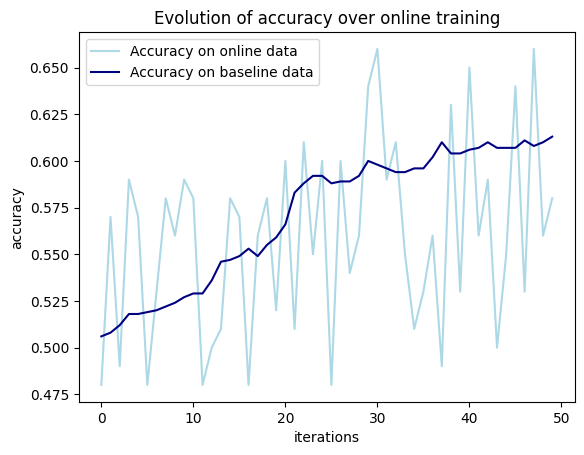

In [22]:
# plot the accuracies as a function of iterations
import matplotlib.pyplot as plt

plt.figure()
# plt.plot(range(1, 1+len(accuracies)), accuracies, color="red")
plt.plot(accuracies, label="Accuracy on online data", color="lightblue")
plt.plot(baseline_accuracies, label="Accuracy on baseline data", color="navy")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.title("Evolution of accuracy over online training")
plt.show()

---